# 1.0 Model Creation and Training

In [ ]:
#installing necessary libraries
!pip install yfinance
!pip install findspark
!pip install pyspark
!pip install vaderSentiment

In [2]:
import pandas as pd
import csv
import datetime
import yfinance as yf
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup as bs
import requests
from pyspark.sql.functions import sum,max,min,mean,count
import datetime as dt
import pyspark
from pyspark.sql import SparkSession
import findspark
import yaml
from yaml.loader import SafeLoader
from os.path import abspath
!git clone https://github.com/JollygreenG-10/BigData.git

Cloning into 'BigData'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 77
Unpacking objects: 100% (94/94), 5.97 MiB | 7.45 MiB/s, done.


## 1.1 Read in CSV Files Containing Data for Target Companies

In [3]:
from os import listdir
import pandas as pd
path = '/content/BigData/Final_project_files/data/'

from sklearn.preprocessing import MinMaxScaler
#Function to read in csv files and scale columns for data where scaling of predictions is eventually needed
def scale(path):
    scaler_list = []
    target_list = []
    feat_list = []
    for item in listdir(path):
        df = pd.read_csv(path + str(item))
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #create scaler instances
        scaler = MinMaxScaler(feature_range=(0,1))
        target_scaler = MinMaxScaler(feature_range = (0,1))
        data = df.drop(['ticker'],axis=1)
        # scale features and target columns
        target = target_scaler.fit_transform(data[['target']])
        target = target.flatten()
        scaler_list.append(target_scaler)
        target_list.append(target)
        X_feat = data.drop(['target'], axis = 1)
        for col in X_feat.columns:
            X_feat[col] = scaler.fit_transform(X_feat[[col]])
        feat_list.append(X_feat)
    return scaler_list, target_list, feat_list
scaler_list, target_list, feat_list = scale(path) 

In [4]:
#Split training and test data (microsoft and google) was well as features and targets
test_data = feat_list[0]   
test_target = target_list[0]
train_data = feat_list[1] 
train_target = target_list[1]
print(train_data.reset_index().info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1802 entries, 0 to 1801
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1802 non-null   datetime64[ns]
 1   open        1802 non-null   float64       
 2   high        1802 non-null   float64       
 3   low         1802 non-null   float64       
 4   close       1802 non-null   float64       
 5   adj_close   1802 non-null   float64       
 6   volume      1802 non-null   float64       
 7   tenmda      1802 non-null   float64       
 8   twentymda   1802 non-null   float64       
 9   fiftymda    1802 non-null   float64       
 10  hundredmda  1802 non-null   float64       
 11  EWMA_20     1802 non-null   float64       
 12  EWMA_50     1802 non-null   float64       
 13  EWMA_100    1802 non-null   float64       
 14  rsi         1802 non-null   float64       
 15  MiddleBand  1802 non-null   float64       
 16  UpperBand   1802 non-nul

In [5]:
# Split data into X_train and y_train data sets
import numpy as np
def lstm_split(data,target,steps):
      X = []
      y = []
      # Creating a data structure with 10 time-steps and 1 output
      for i in range(10, steps):
          X.append(data[i-10:i])
          y.append(target[i])  
      return np.array(X),np.array(y)
 
X1,y1 = lstm_split(train_data, train_target,len(train_data))

#Define Training and Test Datasets
def train_split(x1, y1, train_data):
  train_split = 0.9
  split_idx = int(np.ceil(len(X1)*train_split))
  date_index = train_data.index
 
  X_train,X_test = X1[:split_idx],X1[split_idx:]
  y_train,y_test = y1[:split_idx],y1[split_idx:]
  X_train_date,X_test_date = date_index[:split_idx],date_index[split_idx:]
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_split(X1, y1, train_data)
print(X1.shape,X_train.shape,X_test.shape,y_test.shape,y_train.shape)

(1792, 10, 18) (1613, 10, 18) (179, 10, 18) (179,) (1613,)


#2.0 Setup the models LSTM & Prophet models for a single stock 

##2.1 Configure the base LSTM model 
This process involved running a random search function to select best hyperparameters for the network. The results of this search are availble below.


In [6]:
!pip install tensorflow
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.metrics import Precision
from keras.optimizers import Adam
!pip install keras_tuner
import keras_tuner

#define function to create model, optional hyperparameters included to be selected during training
LR = 0.05
def build_model(hp):
  model = Sequential()
  hidden = hp.Choice('n_hidden', [0,1,2,3])
  model.add(LSTM(units = hp.Int('neurons_visible', min_value = X_train.shape[2], max_value = 100, step = 20),
                activation = hp.Choice('activate1', ['sigmoid', 'relu']),
                input_shape = (X_train.shape[1], X_train.shape[2]),
                return_sequences = True if hidden >0 else False))
  #Configure hidden layers based on random search determined hidden layer number
  if hidden > 0:
    for num in range(hidden):
      model.add(Dropout(hp.Float('dropout' +str(num+1), min_value = 0.1, max_value = 0.9, step = 0.3)))
      model.add(LSTM(units = hp.Int('neurons_hidden'+str(num+1), min_value = 20, max_value = 50, step = 10),
                     activation = 'relu', return_sequences = True if num != hidden else False))
      
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  #compile the model
  model.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ['mae'])
  
  return model

#set learning rate and early stopping callbacks
LR_decay = ReduceLROnPlateau('loss', patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                           patience=25, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
#arrange random search class
tune = keras_tuner.RandomSearch(build_model, objective = 'val_loss', max_trials = 50, seed = 1)

#complete training 
tune.search(X_train, y_train, epochs = 200, batch_size = 20, validation_data = (X_test, y_test), callbacks = [LR_decay, Early_stop])

LSTM_model = tune.get_best_models()[0]
LSTM_model.save('main_models/LSTM_model1.h5')
hyperparameters = tune.get_best_hyperparameters()[0]
print(hyperparameters.values)

Trial 50 Complete [00h 00m 29s]
val_loss: 0.11124637722969055

Best val_loss So Far: 0.0008101827697828412
Total elapsed time: 00h 25m 22s
{'n_hidden': 0, 'neurons_visible': 98, 'activate1': 'sigmoid'}


In [7]:
# function to test LSTM predictions
def testmodel(m_path, trainset ):
  from keras.models import load_model
  model = load_model(m_path)
  m_pred = model.predict(trainset)
  return m_pred

In [8]:
#test LSTM model using X_train for MSFT
LSTM_MSFT_test = testmodel('main_models/LSTM_model1.h5', X_test)
LSTM_MSFT_test.shape

6/6 [==============================] - 0s 6ms/step


(179, 1)

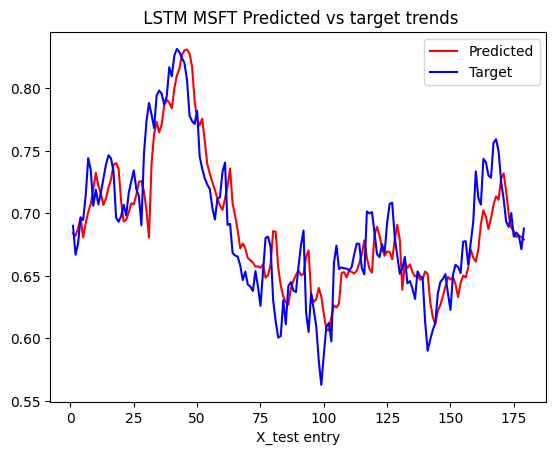

In [9]:
import matplotlib.pyplot as plt
x=np.arange(1,len(y_test)+1, 1)
plt.plot(x,LSTM_MSFT_test.flatten(), "r", label= "Predicted")
plt.plot(x,y_test, "b", label= "Target")

plt.title(" LSTM MSFT Predicted vs target trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

## 2.2 Configure the Prophet Model

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
!pip install yfinance
import yfinance as yf
import datetime as dt

#Generate basic financial data from yfinance for prophet training
def prophet_data(ticker, start_day, month, year):
    delta = dt.timedelta(days = 150)
    data = yf.download(ticker, (dt.date(year, month, start_day) - delta)).reset_index()
    print(data.head())
    data = data.rename(columns = {'Date':'ds', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Adj Close': 'y', 'Volume':'volume'})
    print(data.head())
    data = data.loc[:,['ds', 'y']]
    return data

MSFT_data = prophet_data('MSFT',1, 1,2016)
GOOG_data = prophet_data('GOOG', 1, 1, 2016)


In [ ]:
# Define parameter grid to search over
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
}

# Initialize minimum error and best parameters
min_error = float('inf')
best_params = {}

# Loop through all parameter combinations
for params in ParameterGrid(param_grid):
    print('Testing parameters:', params)

    # Initialize Prophet model with specified hyperparameters
    model = Prophet(**params)
    model.fit(MSFT_data)

    # Perform time series cross-validation
    df_cv = cross_validation(model=model, initial='1000 days', horizon='10 days', period='10 days')

    # Calculate performance metrics
    df_metrics = performance_metrics(df_cv)

    # Calculate mean cross-validation error
    mean_cv_error = df_metrics['mse'].mean()

    # Update minimum error and best parameters if new minimum is found
    if mean_cv_error < min_error:
        min_error = mean_cv_error
        best_params = params

# Print best hyperparameters and corresponding error
print('Best parameters:', best_params)
print('Minimum cross-validation error:', min_error)

### 2.2.1 Train Prophet Models for Microsoft and Google

In [ ]:
# We use the best parameter to fit the model
def get_data(df):
  Best_parameters={'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
  # We use the best parameter to fit the model
  final_model = Prophet(**Best_parameters)
  final_model.fit(df)
  df = cross_validation(model=final_model, initial='100 days', horizon='10 days', period='10 days')
  return df

#generate msft and google prediction datasets 
GOOG_data = get_data(GOOG_data)[['ds', 'yhat']]
MSFT_data = get_data(MSFT_data)[['ds', 'yhat']]


In [ ]:
def prep_prophet(prophet_pred, data1):
  print(prophet_pred.info())
  prophet_pred = prophet_pred.rename(columns = {'ds': 'date'}).set_index('date')
  main_data = data1.join(prophet_pred,how = 'left')
  scale = MinMaxScaler()
  main_data['yhat'] = scale.fit_transform(main_data[['yhat']])
  returned = main_data.loc['2016-01-01':'2023-03-01', 'yhat']
  return returned

Goog_data_proph = prep_prophet(GOOG_data, test_data)[10:]
Msft_train_proph= prep_prophet(MSFT_data, train_data)[10:1623]
Msft_test_proph = prep_prophet(MSFT_data, train_data)[1623:]

## 2.3 Create Dataset to train hybrid model

In [14]:
from keras.saving.legacy.save import load_model

#create training data using predictions from lstm and prophet
lstm = load_model('main_models/LSTM_model1.h5')
def return_hybrid_data(lstm_model, prophet_data, LSTM_data, LSTM_target):
  preds_dict = {}
  preds_dict['lstm_pred'] = lstm_model.predict(LSTM_data).flatten()
  print(lstm_model.predict(LSTM_data).shape)
  preds_dict['prophet_pred'] = prophet_data
  hybrid_train = pd.DataFrame(preds_dict)
  hybrid_train, target = lstm_split(hybrid_train, LSTM_target, len(hybrid_train))
  return hybrid_train, target

hybrid_train, target = return_hybrid_data(lstm, Msft_train_proph, X_train, y_train)

51/51 [==============================] - 0s 2ms/step
(1613, 1)


###2.3.1 Configure Hybrid Model

In [16]:
LR = 0.01
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam

#General LSTM model based on randomsearch results
def multiple_models(x_train, y_train):
    hybrid = Sequential()
    hybrid.add(LSTM(units = 58, activation = "sigmoid", input_shape = (x_train.shape[1], x_train.shape[2]), return_sequences = False))
    hybrid.add(Dropout(0.7))
    hybrid.add(Dense(units =1))
    hybrid.compile(loss = 'mean_squared_error', optimizer = Adam(lr = LR), metrics = ["mae"])
    Early_stop = EarlyStopping(monitor='loss', min_delta=0, 
                              patience=25, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)
    hybrid = hybrid.fit(x_train, y_train, epochs = 50, batch_size = 20, callbacks = [Early_stop])
    return hybrid
    
#train the hybrid model
hybrid1 = multiple_models(hybrid_train, y_train[10:])
hybrid1.model.save('main_models/hybrid1.h5')

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


81/81 [==============================] - 2s 6ms/step - loss: 0.1323 - mae: 0.2783
Epoch 2/50
81/81 [==============================] - 1s 7ms/step - loss: 0.0308 - mae: 0.1360
Epoch 3/50
81/81 [==============================] - 0s 6ms/step - loss: 0.0156 - mae: 0.0937
Epoch 4/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0142 - mae: 0.0898
Epoch 5/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0126 - mae: 0.0851
Epoch 6/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0126 - mae: 0.0869
Epoch 7/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0121 - mae: 0.0823
Epoch 8/50
81/81 [==============================] - 0s 6ms/step - loss: 0.0117 - mae: 0.0829
Epoch 9/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0111 - mae: 0.0793
Epoch 10/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0104 - mae: 0.0778
Epoch 11/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0103 

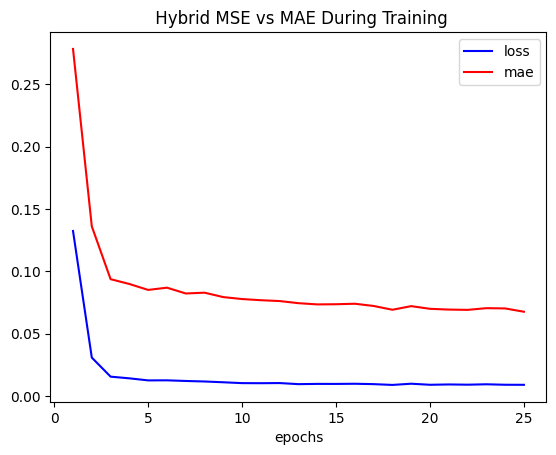

In [17]:
import matplotlib.pyplot as plt
x=np.arange(1,len(hybrid1.history['loss'])+1, 1)
plt.plot(x,hybrid1.history['mse'], "b", label= "mse")
plt.plot(x,hybrid1.history['mae'], "r", label= "mae")

plt.title(" Hybrid MSE vs MAE During Training")
plt.xlabel('epochs')
plt.legend()
plt.show()

##2.4 Test Single Company Models (LSTM vs. Hybrid)

In [18]:
#Configure LSTM test using google data and micosoft validation data
goog_test, goog_target = lstm_split(test_data, test_target, len(test_data))
LSTM_predictions = lstm.predict(goog_test)
LSTM_validation = lstm.predict(X_test).flatten()

#Generate google and microsoft test data for hybrid model
google_ft, google_target = return_hybrid_data(lstm, Goog_data_proph, goog_test, goog_target)
hybrid_val_feat, hybrid_val_target = return_hybrid_data(lstm, Msft_test_proph, X_test, y_test)


56/56 [==============================] - 0s 3ms/step
(1792, 1)
6/6 [==============================] - 0s 5ms/step
(179, 1)


###2.4.1 LSTM vs Hybrid predictions of Microsoft Validation Data

6/6 [==============================] - 0s 3ms/step


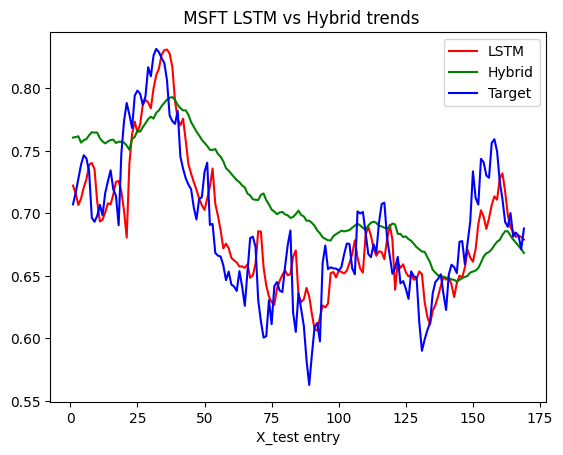

In [19]:
#ploting MSFT LSTM vs Hybrid predictions
import matplotlib.pyplot as plt
hybrid_MSFT_predictions = hybrid1.model.predict(hybrid_val_feat)

x=np.arange(1,len(LSTM_validation[10:])+1,1)
plt.plot(x, LSTM_validation[10:], "r", label= "LSTM")
plt.plot(x,hybrid_MSFT_predictions, "g", label= "Hybrid")
plt.plot(x,y_test[10:], "b", label= "Target")

plt.title(" MSFT LSTM vs Hybrid trends")
plt.xlabel('X_test entry')
plt.legend()
plt.show()

**From the graph above we can see that the performance of the hybrid model(green) on validation data has reduced accuracy compared to the LSTM model (red)**

###2.4.2 Google Predicitions on Microsoft Model ( LSTM vs Hybrid)

56/56 [==============================] - 0s 3ms/step


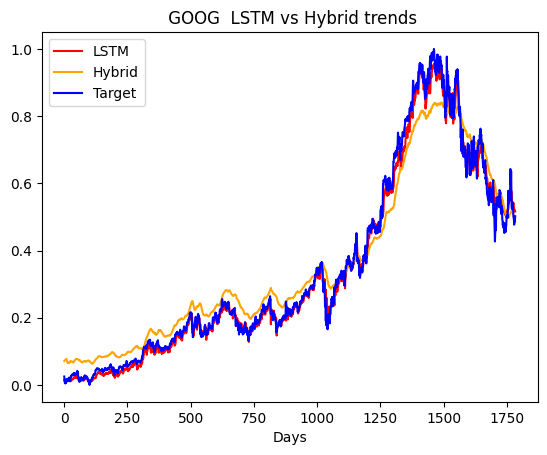

In [51]:
#ploting GOOG LSTM vs Hybrid predictions
import matplotlib.pyplot as plt
goog_predictions_hybrid = hybrid1.model.predict(google_ft)

x=np.arange(1,len(LSTM_predictions[10:])+1,1)
plt.plot(x, LSTM_predictions[10:], "r", label= "LSTM")
plt.plot(x,goog_predictions_hybrid, "orange", label= "Hybrid")
plt.plot(x,goog_target[10:], "b", label= "Target")

plt.title(" GOOG  LSTM vs Hybrid trends")
plt.xlabel('Days')
plt.legend()
plt.show()

F**rom the graph above we can see that the performance of the hybrid model(orange) for an unseen stock (GOOG) has reduced accuracy compared to the LSTM model (red)**

In [47]:
#define function to evaluate model results
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.MeanSquaredError()
    mse.update_state(true_series, forecast)
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(true_series, forecast)
    print(f"the mean squre error of the predictions is {mse.result().numpy()}, and the mean absolute error of the predictions is {mae.result().numpy()}")
    return mse.result().numpy(), mae.result().numpy()

#3.0 Building the Expanded Hybrid Model

In [24]:
LR = 0.01
    
def create_data_lists(list_of_feats, list_of_targets):
  training_list = []
  target_list = []
  for data, target in zip(list_of_feats, list_of_targets):
    data_x, data_y = lstm_split(data, target, len(data))
    print(data_x.shape)
    training_list.append(data_x)
    target_list.append(data_y)
  return training_list, target_list

#Train each of the lstm models on training companies
path = '/content/BigData/Final_project_files/expanded_data/'
ticker_list = ["MSFT", "NFLX", "AMZN", "TSLA"]
hybrid_scalers, targets, frames = scale(path)
training_list, target_list = create_data_lists(frames, targets)

for tick, x_train, y_train in zip(ticker_list, training_list, target_list):
  model = multiple_models(x_train, y_train)
  model.model.save('sub_models/'+tick+'_lstm.h5')

(1792, 10, 18)
(1792, 10, 18)
(1792, 10, 18)
(1792, 10, 18)
Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


90/90 [==============================] - 1s 4ms/step - loss: 0.1396 - mae: 0.2554
Epoch 2/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0239 - mae: 0.1200
Epoch 3/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0160 - mae: 0.0946
Epoch 4/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0134 - mae: 0.0867
Epoch 5/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0125 - mae: 0.0828
Epoch 6/50
90/90 [==============================] - 0s 5ms/step - loss: 0.0106 - mae: 0.0793
Epoch 7/50
90/90 [==============================] - 1s 6ms/step - loss: 0.0109 - mae: 0.0784
Epoch 8/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0100 - mae: 0.0738
Epoch 9/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0089 - mae: 0.0719
Epoch 10/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0093 - mae: 0.0726
Epoch 11/50
90/90 [==============================] - 1s 7ms/step - loss: 0.0098 

## 3.1 Train Expanded Hybrid Model Using Predictions of all Sub-Models

In [25]:
#Create Train Data for Hybrid Model Using Microsoft Predictions
from keras.saving.legacy.save import load_model
import os
def hybrid_trainer(direct, ticker_list, hybrid_train):
    preds_dict = {}
    path = direct
    for num, model in enumerate(os.listdir(path)):
        model = load_model(path+model)
        prediction = model.predict(hybrid_train).flatten()
        print(prediction.shape)
        preds_dict[ticker_list[num]] = prediction
    preds_df = pd.DataFrame(preds_dict)
    return preds_df

#generate training data for expanded hybrid model
hybrid_training_data =  hybrid_trainer('sub_models/', ticker_list, X_train) 
hybrid_training_data['prophet'] = np.array(Msft_train_proph)
hybrid_training_data, y_train = lstm_split(hybrid_training_data, target_list[0], len(hybrid_training_data))


51/51 [==============================] - 0s 2ms/step
(1613,)
51/51 [==============================] - 0s 2ms/step
(1613,)
51/51 [==============================] - 0s 3ms/step
(1613,)
51/51 [==============================] - 0s 2ms/step
(1613,)


In [26]:
#Create and train the expanded hybrid model
hybrid_expanded = multiple_models(hybrid_training_data, y_train)
hybrid_expanded.model.save('main_models/hybrid_expanded.h5')

Epoch 1/50


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


81/81 [==============================] - 2s 7ms/step - loss: 0.1291 - mae: 0.2608
Epoch 2/50
81/81 [==============================] - 1s 7ms/step - loss: 0.0331 - mae: 0.1416
Epoch 3/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0198 - mae: 0.1049
Epoch 4/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0158 - mae: 0.0900
Epoch 5/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0166 - mae: 0.0905
Epoch 6/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0133 - mae: 0.0811
Epoch 7/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0125 - mae: 0.0791
Epoch 8/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0134 - mae: 0.0790
Epoch 9/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0124 - mae: 0.0781
Epoch 10/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0118 - mae: 0.0749
Epoch 11/50
81/81 [==============================] - 0s 5ms/step - loss: 0.0122 

## 3.2 Test the Expanded Hybrid Model on Microsoft and Goole Test Data


In [43]:
#Configure hybrid model testing data based on predictions from each of the four underlying models and prophet
from os import listdir
google_test = {}
microsoft_test = {}
path = 'sub_models/'
for num, model in enumerate(os.listdir(path)):
  model = load_model(path+model)
  goog_preds = model.predict(goog_test).flatten()
  micro_preds = model.predict(X_test).flatten()
  google_test[ticker_list[num]] = goog_preds
  microsoft_test[ticker_list[num]] = micro_preds
google_test = pd.DataFrame(google_test)
microsoft_test = pd.DataFrame(microsoft_test)

#set Prophet data
google_test['prophet'] = np.array(Goog_data_proph)
microsoft_test['prophet'] = np.array(Msft_test_proph)
#Create final test data for hybrid model
google_test, goog_y = lstm_split(google_test, goog_target, len(google_test))
microsoft_test, msft_y = lstm_split(microsoft_test, y_test, len(microsoft_test))

[0.01286917 0.01633901 0.02429326 ... 0.48498674 0.48677707 0.50212282]
6/6 [==============================] - 0s 3ms/step
[0.01286917 0.01633901 0.02429326 ... 0.48498674 0.48677707 0.50212282]
6/6 [==============================] - 0s 4ms/step
[0.01286917 0.01633901 0.02429326 ... 0.48498674 0.48677707 0.50212282]
6/6 [==============================] - 0s 5ms/step
[0.01286917 0.01633901 0.02429326 ... 0.48498674 0.48677707 0.50212282]
6/6 [==============================] - 0s 5ms/step
(179, 4)
(179,)
         MSFT      NFLX      AMZN      TSLA   prophet
0    0.665556  0.718860  0.614846  0.723104  0.921486
1    0.644559  0.694823  0.589594  0.714031  0.924630
2    0.644406  0.695252  0.600593  0.721519  0.926640
3    0.665207  0.720650  0.631714  0.744373  0.929466
4    0.650449  0.703378  0.611023  0.719832  0.910446
..        ...       ...       ...       ...       ...
174  0.685141  0.734081  0.651268  0.724153  0.674441
175  0.677332  0.725428  0.644149  0.716017  0.671979
176  0

In [44]:
#Predict google and microsoft test data using the trained hybrid model
hybrid_expanded = load_model('main_models/hybrid_expanded.h5')
expanded_msft_predictions = hybrid_expanded.predict(microsoft_test)
expanded_goog_predictions = hybrid_expanded.predict(google_test)

56/56 [==============================] - 0s 2ms/step


In [48]:
#prepare all predictions
#lstm
msft_lstm_mse, msft_lstm_mae = compute_metrics(y_test, LSTM_MSFT_test)
goog_lstm_mse, goog_lstm_mae = compute_metrics(goog_target, LSTM_predictions)

#single hybrid
msft_single_mse, msft_single_mae = compute_metrics(y_test[10:], hybrid_MSFT_predictions)
goog_sinlge_mse, goog_single_mae = compute_metrics(google_target, goog_predictions_hybrid)

#expanded_hybrid
msft_expanded_mse, msft_expanded_mae = compute_metrics(msft_y, expanded_msft_predictions)
goog_expanded_mse, goog_expanded_mae = compute_metrics(goog_y, expanded_goog_predictions)

0.00081018265 0.022252623
0.0006168668 0.01764952
0.0027079852 0.043142103
0.0036318116 0.050165597
0.014844061 0.11616008
0.035539616 0.16288233


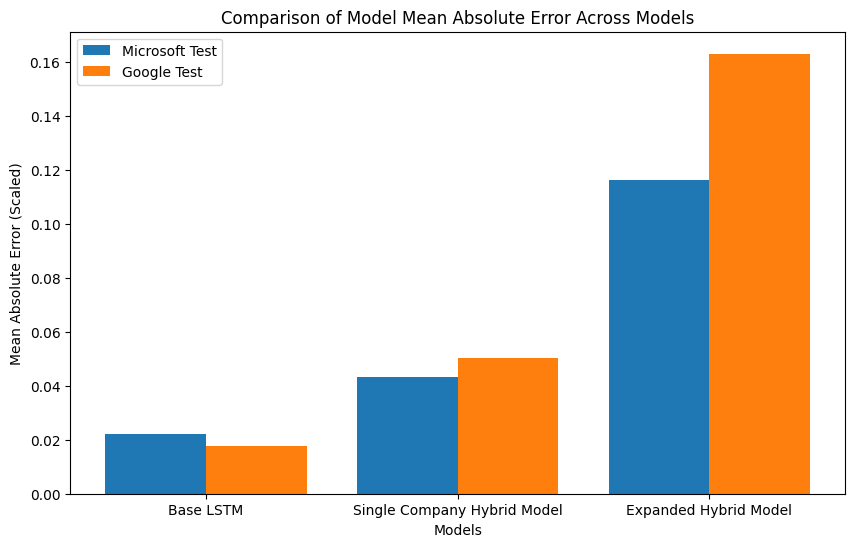

' mse, mae = compute_metrics(y1, predictions)\nprint(mae)\nplt.plot(y1, label="actual")\nplt.plot(predictions, label="predicted")\nplt.xlabel("Timesteps")\nplt.ylabel("Value")\nplt.tight_layout()\nsns.despine(top=True)\nplt.subplots_adjust(left=0.07)\nplt.legend()\nplt.show() '

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
x = ['Base LSTM', 'Single Company Hybrid Model', "Expanded Hybrid Model"]
msft = [msft_lstm_mae, msft_single_mae, msft_expanded_mae]
goog = [goog_lstm_mae, goog_single_mae, goog_expanded_mae]
X_axis = np.arange(len(x))
plt.figure(figsize=(10, 6))
plt.bar(X_axis - 0.2, msft, 0.4, label = 'Microsoft Test')
plt.bar(X_axis + 0.2, goog, 0.4, label = 'Google Test')
  
plt.xticks(X_axis, x)
plt.xlabel("Models")
plt.ylabel("Mean Absolute Error (Scaled)")
plt.title("Comparison of Model Mean Absolute Error Across Models")
plt.legend()
plt.show()


''' mse, mae = compute_metrics(y1, predictions)
print(mae)
plt.plot(y1, label="actual")
plt.plot(predictions, label="predicted")
plt.xlabel("Timesteps")
plt.ylabel("Value")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.legend()
plt.show() '''